In [1]:
# Download all data for a specific tile
# Generate the annual cloud-free composite 
# Download TML features 
# Generate the plantations predictions
# Upload plantation predictions to s3

## GHANA TILES
#tile_idx = (1660, 1161) # need to redo preds on this one
#tile_idx = (1163, 835) # check bounding box
#tile_idx = (1666, 1161)
#tile_idx = (1674, 1085)
#tile_idx = (1678, 1163)
#tile_idx = (1679, 1163)
#tile_idx = (1676, 1162)
#tile_idx = (1677, 1162)
#tile_idx = (1678, 1162)
#tile_idx = (1679, 1162)
#tile_idx = (1680, 1162)
#tile_idx = (1681, 1162)
#tile_idx = (1650, 1049)
# (1654, 1051)
# (1646, 1050)
# (1644, 1052)
# (1644, 1053)
# (1645, 1052)
# (1645, 1053)
# (1646, 1052)
# (1646, 1053)


## COSTA RICA TILES
# (440 1165)
# (441 1165)
# (439 1163)
# (484 1114)
# (476 1117)
# (413 1063)

In [40]:
import pandas as pd
import geopandas as gpd
import numpy as np
import hickle as hkl
import pickle
import seaborn as sns
import copy
import os
import boto3
import confuse
import rasterio
from osgeo import gdal
import time
from scipy.ndimage import median_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
import rasterio as rs
import sys
sys.path.append('../src/')
#import plantation_classifier as p
import mosaic as m
from prototype import prepare_data as ptype
import yaml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Errors / Prototyping

## Feature incorporation

In [178]:
np.max(preds)

99

In [125]:
folder = f"../tmp/ashanti/{str(x)}/{str(y)}/"
tile_idx = '1660X1075Y'

feats_file = f'{folder}raw/feats/{tile_idx}_feats.hkl'
feats_full = hkl.load(feats_file)

In [165]:
if feats_full.shape[0] != 65:
    print(f'Warning: there are only {feats_full.shape[0]} feats')
    
# separate preds and feats
preds = feats_full[0]
feats = feats_full[1:, ...] / 1000

# combine... there's prob an easier way?
comb = np.empty((feats_full.shape[0], feats_full.shape[1], feats_full.shape[2]))
comb[0,...] = preds
comb[1:,...] = feats

#  adjust shape from (65, 614, 618) ->  (618, 614, 65) 
# and make sure float32
comb = np.rollaxis(comb, 0, 3)
comb = np.rollaxis(comb, 0, 2)
tml_feats = comb.astype(np.float32)

In [166]:
tml_feats.shape

(618, 614, 65)

In [167]:
tml_feats.dtype

dtype('float32')

In [168]:
tml_feats[...,0]

array([[95., 96., 95., ..., 93., 98., 98.],
       [96., 96., 94., ..., 87., 90., 93.],
       [97., 96., 95., ..., 85., 83., 86.],
       ...,
       [74., 65., 63., ..., 84., 76., 67.],
       [74., 76., 68., ..., 75., 67., 55.],
       [66., 70., 51., ..., 44., 57., 40.]], dtype=float32)

In [169]:
tml_feats[...,1]

array([[-0.06 , -0.292,  0.038, ...,  0.058,  0.205,  0.315],
       [-0.139, -0.296, -0.042, ..., -0.041,  0.12 ,  0.12 ],
       [-0.055, -0.178,  0.004, ..., -0.322, -0.287, -0.077],
       ...,
       [ 0.012, -0.21 , -0.35 , ..., -0.17 , -0.127, -0.236],
       [-0.007,  0.069, -0.11 , ...,  0.038, -0.162, -0.141],
       [-0.107, -0.028, -0.153, ..., -0.184, -0.075, -0.27 ]],
      dtype=float32)

In [136]:
preds = preds

In [137]:
preds.shape

(1, 614, 618, 1)

In [93]:
tile_idx = (1660, 1075)
x = tile_idx[0]
y = tile_idx[1]

feats = hkl.load(f'{folder}raw/feats/{str(x)}X{str(y)}Y_feats.hkl')


(65, 614, 618)

In [21]:
# the new feats tile contains the predictions (0-100) at index 0
# the other indexes are the feats and need to be divided by 1,000 bc they are int16 dtype
# import feats to take a look
folder = f"../tmp/ashanti/{str(1658)}/{str(1074)}/"
tile_idx = f'1658X1074Y'
tml_feats = hkl.load(f'{folder}raw/feats/{tile_idx}_feats.hkl')
new_feats = hkl.load(f'{folder}raw/feats/{tile_idx}_feats_new.hkl')
tml_preds = rs.open(f'{folder}raw/feats/{tile_idx}_FINAL.tif').read(1)
tml_feats.shape, new_feats.shape, tml_preds.shape

((64, 614, 618), (64, 614, 618), (618, 614))

In [22]:
tml_feats[0]

array([[-219,  -64,  201, ..., -126,  -80,   -7],
       [ -22, -269, -210, ..., -185, -204, -186],
       [-108, -119, -287, ...,  -57, -178,  154],
       ...,
       [ 217,  374, -301, ...,   -9, -277, -297],
       [-290, -239, -484, ...,  113,  310, -284],
       [ 432,  448,  297, ..., -202, -117, -100]], dtype=int16)

In [23]:
new_feats[0]

array([[-219,  -64,  201, ..., -126,  -80,   -7],
       [ -22, -269, -210, ..., -185, -204, -186],
       [-108, -119, -287, ...,  -57, -178,  154],
       ...,
       [ 217,  374, -301, ...,   -9, -277, -297],
       [-290, -239, -484, ...,  113,  310, -284],
       [ 432,  448,  297, ..., -202, -117, -100]], dtype=int16)

In [ ]:
# tml_feats = np.rollaxis(tml_feats, 0, 3)
# tml_feats = np.rollaxis(tml_feats, 0, 2)

In [30]:
tml_preds = tml_preds[..., np.newaxis]
tml_preds.shape

(1, 618, 614, 1)

In [25]:
# test run preds without TML features to enable comparison
p.execute((1658,1074), 'ashanti', 'cat_model_v11_nf')

Exists locally.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[100. 100. 100. ...   0.   0.   0.]
 [100. 100. 100. ...   0.   0.   0.]
 [100.   0.   0. ...   0.   0.   0.]
 ...
 [  0. 100. 100. ...   0.   0.   0.]
 [100. 100.   0. ...   0.   0.   0.]
 [100. 100.   0. ...   0.   0.   0.]]
Writing ../tmp/ashanti/preds/1658X1074Y_preds.tif


In [32]:
# test run preds with TML features
p.execute((1658,1074), 'ashanti', 'cat_model_v11')

Exists locally.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


(618, 614, 78)
[[100. 100.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0. 100.]]
Writing ../tmp/ashanti/preds/1658X1074Y_preds.tif


In [68]:
p.execute((1658,1074), 'ashanti', 'cat_model_v11')

Exists locally.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


(618, 614, 78)
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Baseline: 0.409
(618, 614, 78)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.14873744547367096, 0.03137637674808502, 1849.5, 3076.0, 1971.7350000000001, 14315.97, 4482.235, 12231.735, 14227.235, 15842.0, 9402.235, 4205.235, 0.035097129940986634, -0.9327185106277466, -0.64780164182186

In [26]:
feats_file = f'../tmp/ashanti/1658/1074/raw/feats/1658X1074Y_feats.hkl'
tml_feats = hkl.load(feats_file).astype(np.float32)
# tml_feats = np.rollaxis(tml_feats, 0, 3)
# tml_feats = np.rollaxis(tml_feats, 0, 2)
tml_feats.shape

(64, 614, 618)

In [44]:
X, y = ptype.create_xy((14, 14), ['v08', 'v11'], drop_prob=False, drop_feats=False, verbose=False)
X.shape

Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Baseline: 0.409


(313, 14, 14, 78)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)

In [46]:
X_train.shape

(209, 14, 14, 78)

# Regional tests

### Puntarenas

In [7]:
costarica = pd.read_csv('../data/costarica.csv')

In [15]:
punta = pd.read_csv('../data/puntarenas.csv')
punta

,X,Y,Y_tile,X_tile,country,NAME_1
0,-84.3611,9.6389,1137,462,Costa Rica,Puntarenas
1,-84.3056,9.6389,1137,463,Costa Rica,Puntarenas
2,-84.3611,9.5833,1136,462,Costa Rica,Puntarenas
3,-84.3056,9.5833,1136,463,Costa Rica,Puntarenas
4,-84.2500,9.5833,1136,464,Costa Rica,Puntarenas
...,...,...,...,...,...,...
222,-83.1389,8.3611,1114,484,Costa Rica,Puntarenas
223,-83.0833,8.3611,1114,485,Costa Rica,Puntarenas
224,-83.0278,8.3611,1114,486,Costa Rica,Puntarenas
225,-83.0278,8.3056,1113,486,Costa Rica,Puntarenas


In [15]:
punta = pd.read_csv('../data/puntarenas.csv')

punta_tiles = punta[['X_tile', 'Y_tile']].to_records(index=False)

In [17]:
for tile in punta_tiles[:2]:
    print(tile)

(462, 1137)
(463, 1137)


In [20]:
successful = False
if not successful:
    print('successful')

successful


In [34]:
# produce puntarenas map w/ first 100 tiles

punta = pd.read_csv('../data/puntarenas.csv')

punta_tiles = punta[['X_tile', 'Y_tile']].to_records(index=False)

counter = 0

for tile in punta_tiles[:5]:
    print(tile)
#     counter += 1
#     p.execute(tile, 'puntarenas', 'cat_model_v10_nf')
#     print(f'{counter} completed.')

(462, 1137)
(463, 1137)
(462, 1136)
(463, 1136)
(464, 1136)


In [17]:
m.mosaic_tif('puntarenas', 'cat_model_v11_nf', '081122')

Merging 227 tifs.


### Parrita

In [19]:
parrita = pd.read_csv('../data/parrita.csv')

tiles = parrita[['X_tile', 'Y_tile']].to_records(index=False)

counter = 0

for tile in tiles:
    counter += 1
    p.execute(tile, 'parrita', 'rfr_model_v11_nf')
    if counter % 5 == 0:
        print(f'{counter}/{len(parrita)} completed.')

[[82. 82. 95. ... 48. 18. 20.]
 [89. 46. 57. ... 53. 43. 56.]
 [97. 58. 53. ... 57. 39. 51.]
 ...
 [87. 97. 99. ... 17. 13. 17.]
 [74. 96. 98. ... 27. 25. 23.]
 [68. 98. 93. ... 35. 23. 22.]]
Writing ../tmp/parrita/preds/462X1137Y_preds.tif
[[82. 82. 80. ... 56. 48. 34.]
 [89. 88. 74. ... 40. 53. 46.]
 [66. 52. 83. ... 29. 43. 63.]
 ...
 [11. 22. 49. ... 54. 36. 29.]
 [16. 16.  1. ... 33. 34. 39.]
 [16. 16.  1. ... 41. 51. 39.]]
Writing ../tmp/parrita/preds/463X1137Y_preds.tif
[[95. 95. 92. ... 16. 27. 32.]
 [82. 54. 74. ... 49. 48. 59.]
 [94. 70. 79. ... 42. 46. 72.]
 ...
 [25. 25. 52. ... 60. 57. 71.]
 [51. 48. 48. ... 70. 74. 73.]
 [49. 52. 30. ... 65. 65. 72.]]
Writing ../tmp/parrita/preds/462X1136Y_preds.tif
[[27. 27. 55. ... 50. 47. 40.]
 [61. 46. 49. ... 47. 47. 44.]
 [65. 67. 45. ... 64. 56. 43.]
 ...
 [60. 46. 48. ... 63. 52. 81.]
 [52. 52. 48. ... 59. 81. 72.]
 [55. 52. 45. ... 65. 77. 81.]]
Writing ../tmp/parrita/preds/463X1136Y_preds.tif
[[ 3.  3.  5. ... 29. 25. 30.]
 [ 6.

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 9.  9.  7. ... 60. 63. 47.]
 [14. 13. 17. ... 46. 50. 42.]
 [10.  9. 14. ... 33. 49. 50.]
 ...
 [21. 21.  6. ... 37. 40. 43.]
 [20. 16. 10. ... 37. 42. 38.]
 [ 8.  0.  2. ... 31. 31. 61.]]
Writing ../tmp/parrita/preds/465X1136Y_preds.tif
[[59. 59. 57. ... 58. 64. 63.]
 [60. 36. 39. ... 59. 65. 66.]
 [58. 34. 36. ... 63. 65. 66.]
 ...
 [25. 25. 24. ... 74. 74. 74.]
 [24. 24. 24. ... 74. 75. 73.]
 [25. 25. 29. ... 74. 74. 73.]]
Writing ../tmp/parrita/preds/461X1135Y_preds.tif
[[54. 54. 32. ... 75. 19. 64.]
 [40. 40. 48. ... 67. 80. 74.]
 [18. 18. 18. ... 63. 59.  1.]
 ...
 [72. 72. 72. ... 41. 41. 38.]
 [72. 72. 72. ... 40. 39. 37.]
 [72. 72. 72. ... 38. 40. 39.]]
Writing ../tmp/parrita/preds/462X1135Y_preds.tif
[[54. 54. 62. ... 83. 78. 65.]
 [66. 66. 29. ... 80. 81. 76.]
 [24. 24. 23. ... 55. 57. 49.]
 ...
 [50. 49. 49. ... 47. 58. 33.]
 [53. 52. 51. ... 27. 15. 28.]
 [51. 49. 47. ... 11. 16. 13.]]
Writing ../tmp/parrita/preds/463X1135Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[21. 21. 25. ... 23. 24. 26.]
 [17. 52. 52. ... 66. 62. 57.]
 [16. 51. 63. ... 46. 59. 61.]
 ...
 [47. 46. 77. ... 10. 16. 14.]
 [75. 74. 75. ... 21. 27. 39.]
 [62. 61. 57. ... 21. 24. 24.]]
Writing ../tmp/parrita/preds/464X1135Y_preds.tif
10/227 completed.
[[48. 48. 44. ... 82. 75. 67.]
 [46. 67. 62. ... 64. 75. 58.]
 [67. 70. 69. ... 65. 63. 65.]
 ...
 [ 1.  2.  2. ... 45. 20. 46.]
 [ 1.  2.  0. ... 51. 45. 55.]
 [ 6.  9.  4. ... 48. 50. 54.]]
Writing ../tmp/parrita/preds/465X1135Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[61. 61. 42. ... 46. 41. 44.]
 [62. 55. 66. ... 78. 61. 12.]
 [65. 54. 60. ... 63. 43. 43.]
 ...
 [46. 41. 28. ... 24. 70. 79.]
 [30. 24. 34. ... 58. 74. 80.]
 [35. 32. 41. ... 55. 74. 65.]]
Writing ../tmp/parrita/preds/466X1135Y_preds.tif
[[44. 44. 24. ... 73. 58. 61.]
 [34. 33. 22. ... 79. 44. 30.]
 [23. 21. 21. ... 86. 48.  7.]
 ...
 [28. 28. 43. ... 92. 55. 64.]
 [43. 43. 46. ... 60. 50. 49.]
 [37. 37. 47. ... 42. 32. 43.]]
Writing ../tmp/parrita/preds/467X1135Y_preds.tif


../src/cloud_removal.py:560: RuntimeWarning: invalid value encountered in true_divide
  return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])
../src/cloud_removal.py:568: RuntimeWarning: divide by zero encountered in true_divide
  step3 = arr[..., 5] / arr[..., 8] < 4.292
../src/cloud_removal.py:456: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 3] - arr[..., 2]) / (arr[..., 3] + arr[..., 2])
../src/cloud_removal.py:459: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
../src/cloud_removal.py:163: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])


[[27. 27. 27. ... 64. 53. 53.]
 [30. 29. 33. ... 57. 59. 50.]
 [36. 31. 31. ... 72. 75. 69.]
 ...
 [47. 43. 64. ... 44. 49. 60.]
 [61. 57. 55. ... 53. 51. 53.]
 [61. 56. 55. ... 57. 58. 56.]]
Writing ../tmp/parrita/preds/465X1134Y_preds.tif
[[41. 41. 61. ... 66. 59. 42.]
 [54. 52. 43. ... 58. 61. 63.]
 [47. 37. 61. ... 59. 63. 74.]
 ...
 [37.  8.  0. ...  1.  0.  0.]
 [ 4.  1.  4. ...  1.  1.  1.]
 [ 5.  1.  2. ...  1.  1.  7.]]
Writing ../tmp/parrita/preds/466X1134Y_preds.tif
15/227 completed.
[[94. 94. 73. ... 29. 29. 29.]
 [94. 82. 65. ... 28. 30. 35.]
 [97. 95. 88. ... 25. 31. 31.]
 ...
 [40. 38. 48. ... 44. 35. 45.]
 [40. 38. 40. ... 57. 40. 49.]
 [35. 34. 35. ... 45. 65. 44.]]
Writing ../tmp/parrita/preds/467X1134Y_preds.tif


../src/cloud_removal.py:568: RuntimeWarning: divide by zero encountered in true_divide
  step3 = arr[..., 5] / arr[..., 8] < 4.292
../src/cloud_removal.py:508: RuntimeWarning: divide by zero encountered in true_divide
  r8a = b8down / b8adown
../src/cloud_removal.py:509: RuntimeWarning: divide by zero encountered in true_divide
  r8a7 = b7down / b8adown
../src/cloud_removal.py:520: RuntimeWarning: invalid value encountered in subtract
  r8a = mean_of_sq - sq_of_mean
../src/cloud_removal.py:530: RuntimeWarning: invalid value encountered in subtract
  r8a7 = mean_of_sq - sq_of_mean


[[35. 36. 34. ... 11.  7.  8.]
 [40. 54. 40. ...  8.  6.  6.]
 [35. 32. 29. ... 28. 27. 30.]
 ...
 [64. 29. 26. ... 55. 56. 57.]
 [61. 69. 28. ... 53. 56. 56.]
 [24. 24. 24. ... 55. 55. 56.]]
Writing ../tmp/parrita/preds/466X1133Y_preds.tif
[[ 48.  48.  48. ...  49.  64.  53.]
 [ 48.  40.  41. ...  51.  63.  71.]
 [ 48.  42.  40. ...  90.  81.  84.]
 ...
 [ 97. 100.  99. ...  22.  32.  33.]
 [ 90.  99.  50. ...  22.  35.  35.]
 [ 26.  51.  48. ...  26.  32.  38.]]
Writing ../tmp/parrita/preds/467X1133Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 1. 72. 65. ... 60. 63. 57.]
 [79. 64. 77. ... 44. 56. 58.]
 [65. 56. 88. ... 53. 50. 42.]
 ...
 [27. 19. 21. ... 83. 87. 78.]
 [37. 19. 21. ... 83. 87. 88.]
 [21. 16. 24. ... 90. 79. 73.]]
Writing ../tmp/parrita/preds/468X1133Y_preds.tif
[[58. 58. 57. ... 55. 60. 60.]
 [58. 58. 57. ... 59. 62. 61.]
 [56. 56. 56. ... 62. 63. 58.]
 ...
 [71. 69. 69. ... 41. 39. 52.]
 [70. 69. 70. ... 46. 46. 54.]
 [69. 70. 70. ... 52. 46. 57.]]
Writing ../tmp/parrita/preds/468X1132Y_preds.tif
20/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 4.  8.  8. ... 45. 35. 27.]
 [ 8.  6.  8. ... 47. 34. 16.]
 [50. 54.  3. ... 47. 35. 20.]
 ...
 [58. 58. 58. ... 50. 43. 45.]
 [58. 58. 58. ... 27. 27. 32.]
 [58. 58. 58. ... 50. 29. 28.]]
Writing ../tmp/parrita/preds/469X1132Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[52. 58. 83. ... 12. 40. 50.]
 [46. 15. 36. ...  8. 18. 29.]
 [57. 42. 38. ... 15. 14. 22.]
 ...
 [ 2.  1.  0. ... 89. 35. 40.]
 [10.  0.  6. ... 71. 57. 53.]
 [ 5.  3. 11. ... 63. 57. 56.]]
Writing ../tmp/parrita/preds/470X1132Y_preds.tif
[[81. 88. 50. ... 68. 72. 66.]
 [89. 88. 52. ... 59. 73. 83.]
 [88. 88. 35. ... 83. 73. 70.]
 ...
 [75. 61. 47. ... 33. 42. 61.]
 [68. 52. 71. ... 62. 58. 58.]
 [38. 55. 51. ... 54. 57. 58.]]
Writing ../tmp/parrita/preds/479X1132Y_preds.tif
[[36. 29. 21. ... 86. 94. 15.]
 [35. 42. 63. ... 88. 87. 16.]
 [ 1.  0.  3. ... 93. 43. 27.]
 ...
 [28. 55. 54. ... 75. 74. 74.]
 [32. 62. 58. ... 70. 72. 69.]
 [24. 50. 48. ... 73. 65. 75.]]
Writing ../tmp/parrita/preds/481X1132Y_preds.tif
[[38. 38. 33. ... 54. 54. 55.]
 [35. 53. 31. ... 49. 50. 54.]
 [38. 36. 38. ... 60. 50. 50.]
 ...
 [69. 60. 64. ... 24. 22. 27.]
 [61. 68. 64. ... 24. 25. 30.]
 [44. 58. 64. ... 25. 26. 32.]]
Writing ../tmp/parrita/preds/470X1131Y_preds.tif
25/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[58. 49. 46. ...  1. 33. 36.]
 [52. 68. 67. ...  2. 34. 35.]
 [45. 70. 75. ...  3. 28. 28.]
 ...
 [61. 47. 42. ... 77. 92. 90.]
 [56. 51. 40. ... 79. 86. 88.]
 [34. 44. 35. ... 53. 18. 20.]]
Writing ../tmp/parrita/preds/471X1131Y_preds.tif
[[50. 30. 52. ... 42. 69. 73.]
 [45. 28. 57. ... 39. 70. 77.]
 [36. 68. 49. ... 47. 56. 71.]
 ...
 [50. 47. 68. ... 23. 28. 29.]
 [54. 74. 64. ... 22. 24. 25.]
 [64. 72. 55. ... 30. 25. 33.]]
Writing ../tmp/parrita/preds/479X1131Y_preds.tif
[[10. 36. 57. ... 52. 52. 53.]
 [16. 56. 45. ... 50. 49. 53.]
 [59. 36. 41. ... 34. 42. 43.]
 ...
 [35. 44. 43. ... 48.  5.  8.]
 [43. 55. 48. ... 36.  3.  6.]
 [47. 58. 42. ... 35. 19. 19.]]
Writing ../tmp/parrita/preds/480X1131Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 78.  78.  78. ...  54. 100.  99.]
 [ 78.  82.  75. ...  65.  57.  57.]
 [ 80.  76.  67. ...  59.  48.  56.]
 ...
 [ 59.  62.  52. ...   0.   1.   1.]
 [ 51.  59.  36. ...   0.   1.   1.]
 [ 49.  56.  36. ...   0.   1.   1.]]
Writing ../tmp/parrita/preds/481X1131Y_preds.tif
[[46. 80. 49. ... 57. 40. 43.]
 [77. 59. 55. ... 64. 66. 79.]
 [79. 62. 54. ... 71. 70. 87.]
 ...
 [ 0.  0.  3. ... 73. 85. 67.]
 [ 0.  0.  0. ... 85. 68. 69.]
 [ 0.  0.  3. ... 58. 50. 52.]]
Writing ../tmp/parrita/preds/482X1131Y_preds.tif
30/227 completed.
[[60. 93. 78. ... 76. 89. 93.]
 [60. 22. 26. ... 90. 92. 84.]
 [53. 60. 36. ... 76. 71. 91.]
 ...
 [49. 55. 37. ... 63. 55. 60.]
 [38. 49. 39. ... 54. 27. 25.]
 [28. 57. 60. ... 76. 61. 49.]]
Writing ../tmp/parrita/preds/483X1131Y_preds.tif
[[53. 45. 42. ... 51. 55. 53.]
 [43. 46. 44. ... 51. 56. 56.]
 [55. 45. 55. ... 51. 54. 53.]
 ...
 [23. 24. 23. ... 54. 57. 58.]
 [22. 23. 26. ... 54. 59. 58.]
 [25. 24. 25. ... 46. 55. 54.]]
Writing ../tmp/parrita/preds/47

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[65. 39. 24. ... 59. 42. 55.]
 [64.  1. 32. ... 48. 51. 35.]
 [57.  9. 56. ... 66. 55. 53.]
 ...
 [ 3. 28. 12. ... 51. 54. 47.]
 [ 9. 28.  8. ... 47. 61. 61.]
 [ 9. 19.  7. ... 53. 65. 60.]]
Writing ../tmp/parrita/preds/482X1130Y_preds.tif
[[55. 54. 64. ... 37. 69. 69.]
 [67. 55. 65. ... 75. 57. 71.]
 [58. 56. 63. ... 49. 76. 67.]
 ...
 [33. 28. 31. ... 21. 23. 30.]
 [23. 14. 27. ... 22. 27. 32.]
 [16. 28. 21. ... 25. 27. 29.]]
Writing ../tmp/parrita/preds/483X1130Y_preds.tif
[[78. 56. 34. ... 34. 29. 20.]
 [77. 53. 25. ... 80. 17. 34.]
 [73. 69. 76. ... 72. 76. 44.]
 ...
 [ 1. 13.  2. ... 52.  8. 27.]
 [ 0. 17.  3. ...  8. 27. 40.]
 [ 0. 26. 13. ...  5. 49. 45.]]
Writing ../tmp/parrita/preds/484X1130Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[34. 37. 32. ... 46. 46. 46.]
 [32. 21. 28. ... 46. 46. 46.]
 [32. 25. 27. ... 47. 42. 42.]
 ...
 [55. 55. 61. ... 38. 46. 48.]
 [65. 60. 74. ... 52. 41. 40.]
 [64. 70. 76. ... 45. 45. 33.]]
Writing ../tmp/parrita/preds/485X1130Y_preds.tif
40/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[59. 50. 52. ... 60. 56. 62.]
 [49. 49. 55. ... 48. 48. 58.]
 [57. 58. 66. ... 59. 61. 57.]
 ...
 [71. 72. 70. ... 60. 63. 64.]
 [71. 70. 72. ... 56. 57. 63.]
 [72. 70. 72. ... 61. 55. 58.]]
Writing ../tmp/parrita/preds/473X1129Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[14. 14. 10. ... 11.  7.  4.]
 [14. 11.  9. ...  5.  3.  4.]
 [17. 18. 20. ...  5.  4.  4.]
 ...
 [16. 22. 21. ... 53. 69. 69.]
 [20. 26. 18. ... 53. 12. 61.]
 [17. 24. 16. ... 60. 57. 63.]]
Writing ../tmp/parrita/preds/474X1129Y_preds.tif
[[89. 88. 84. ... 67. 72. 41.]
 [87. 71. 69. ... 63. 76. 66.]
 [80. 65. 72. ... 72. 69. 74.]
 ...
 [36. 34. 49. ... 29. 63. 48.]
 [34. 43. 44. ... 44. 72. 51.]
 [14. 41. 39. ... 37. 27. 43.]]
Writing ../tmp/parrita/preds/478X1129Y_preds.tif
[[14. 26. 54. ... 43. 34. 35.]
 [36. 37. 60. ... 23. 40. 22.]
 [41. 24. 40. ... 28. 16. 51.]
 ...
 [74. 86. 72. ...  5. 17. 15.]
 [61. 43. 55. ...  7. 36. 58.]
 [59. 63. 69. ...  7. 35. 57.]]
Writing ../tmp/parrita/preds/479X1129Y_preds.tif
[[28. 65. 18. ... 50. 59. 61.]
 [61. 67. 20. ... 48. 61. 58.]
 [57. 15. 25. ... 53. 63. 60.]
 ...
 [30. 29. 38. ... 45. 41. 36.]
 [23. 23. 38. ... 44. 37. 40.]
 [21. 23. 30. ... 41. 37. 36.]]
Writing ../tmp/parrita/preds/480X1129Y_preds.tif
45/227 completed.
[[43. 39. 40. ... 

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[63. 50. 81. ... 17. 18. 15.]
 [60. 51. 64. ... 23. 22. 23.]
 [58. 19. 38. ... 24. 22. 22.]
 ...
 [87. 47. 26. ... 17.  9.  9.]
 [81. 28. 25. ...  3.  1.  2.]
 [93. 54. 26. ...  3.  2.  2.]]
Writing ../tmp/parrita/preds/483X1129Y_preds.tif
[[ 9. 10. 30. ... 70. 26. 66.]
 [ 3. 38. 36. ... 72. 66. 75.]
 [ 5. 48. 23. ... 55. 72. 59.]
 ...
 [13.  9. 14. ... 56. 49. 65.]
 [11.  5. 13. ... 61. 67. 59.]
 [11.  5. 16. ... 60. 68. 54.]]
Writing ../tmp/parrita/preds/484X1129Y_preds.tif
[[66. 55. 55. ... 47. 43. 36.]
 [54. 61. 69. ... 32. 70. 70.]
 [60. 62. 72. ... 30. 35. 49.]
 ...
 [ 3. 56. 43. ... 43. 81. 72.]
 [36. 72. 72. ... 67. 99. 99.]
 [37. 69. 64. ... 62. 81. 82.]]
Writing ../tmp/parrita/preds/485X1129Y_preds.tif
50/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 0.  1.  0. ... 59. 59. 61.]
 [ 0.  0.  1. ... 59. 60. 60.]
 [ 0.  0.  2. ... 54. 55. 52.]
 ...
 [37. 40. 48. ... 46. 53. 53.]
 [28. 41. 47. ... 55. 55. 52.]
 [40. 48. 49. ... 49. 52. 57.]]
Writing ../tmp/parrita/preds/474X1128Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 2.  2.  3. ... 27. 23. 32.]
 [ 1.  1.  1. ... 23. 24. 31.]
 [ 0.  0.  1. ... 26. 26. 30.]
 ...
 [57. 72. 75. ... 58. 32. 29.]
 [69. 56. 61. ... 55. 32. 25.]
 [ 3.  2. 24. ... 66. 64. 42.]]
Writing ../tmp/parrita/preds/475X1128Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[52. 51. 74. ... 29. 32. 45.]
 [54. 42. 60. ... 28. 72. 84.]
 [44. 46. 56. ... 10. 26. 57.]
 ...
 [ 3. 31.  7. ... 63. 51. 41.]
 [ 4. 33.  5. ... 28. 27. 26.]
 [ 5. 19.  6. ... 30. 29. 51.]]
Writing ../tmp/parrita/preds/478X1128Y_preds.tif
[[51. 51. 75. ... 18. 29. 52.]
 [48. 51. 81. ... 18. 33. 57.]
 [45. 54. 52. ...  4. 44. 33.]
 ...
 [48. 37. 34. ... 13. 23. 28.]
 [34. 37. 38. ... 16. 24. 23.]
 [34. 37. 39. ... 24. 25. 24.]]
Writing ../tmp/parrita/preds/479X1128Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[60. 65. 66. ... 45. 40. 38.]
 [72. 66. 28. ... 34. 33. 34.]
 [69. 61. 45. ... 24. 43. 41.]
 ...
 [35. 35. 31. ... 17. 17. 17.]
 [30. 41. 16. ... 23. 17. 17.]
 [36. 40. 12. ... 24. 17. 17.]]
Writing ../tmp/parrita/preds/480X1128Y_preds.tif
55/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[51. 50. 53. ... 12. 22. 21.]
 [50. 35. 38. ... 10. 16. 12.]
 [53. 36. 33. ... 11. 17. 17.]
 ...
 [21.  3.  6. ... 55. 36. 24.]
 [21.  3.  9. ... 60. 56. 56.]
 [19.  3.  5. ... 54. 59. 60.]]
Writing ../tmp/parrita/preds/481X1128Y_preds.tif
[[45. 62. 63. ... 72. 44. 48.]
 [76. 50.  9. ... 56. 61. 55.]
 [27. 36. 49. ... 72. 60. 48.]
 ...
 [63. 58. 66. ... 47. 63. 67.]
 [56. 86. 62. ... 44. 56. 64.]
 [66. 74. 36. ... 54. 71. 61.]]
Writing ../tmp/parrita/preds/482X1128Y_preds.tif
[[98. 89. 73. ...  5. 30. 30.]
 [75. 55. 68. ... 30. 33. 32.]
 [82. 67. 64. ... 17. 29. 29.]
 ...
 [ 1.  4.  6. ...  0.  0.  0.]
 [ 7. 11. 14. ...  0.  0.  0.]
 [19. 22. 19. ...  0.  0.  0.]]
Writing ../tmp/parrita/preds/483X1128Y_preds.tif
[[ 4. 18.  3. ... 41. 23. 13.]
 [ 3. 10. 31. ... 69. 39. 43.]
 [ 4. 26. 34. ... 34. 20. 19.]
 ...
 [ 0.  0.  0. ... 47. 15. 67.]
 [ 0.  0.  0. ... 60. 60. 65.]
 [ 0.  0.  0. ... 65. 79. 90.]]
Writing ../tmp/parrita/preds/484X1128Y_preds.tif
[[52. 52. 48. ... 64. 40. 32.]
 [43.

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[66. 60. 56. ... 21. 17. 11.]
 [67. 71. 53. ... 23. 19. 18.]
 [61. 68. 51. ... 21. 20. 21.]
 ...
 [20. 25. 15. ... 54. 30. 29.]
 [19. 20. 18. ... 56. 37. 36.]
 [28. 16. 25. ... 57. 52. 35.]]
Writing ../tmp/parrita/preds/475X1127Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[42. 42. 42. ... 24. 22. 27.]
 [39. 40. 40. ... 20. 20. 28.]
 [42. 43. 42. ...  9. 31. 38.]
 ...
 [30. 31. 28. ... 69. 61. 73.]
 [30. 27. 19. ... 68. 76. 75.]
 [26. 10. 15. ... 74. 82. 76.]]
Writing ../tmp/parrita/preds/476X1127Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[13.  7.  9. ...  6. 11. 14.]
 [13.  8.  4. ... 11. 10.  2.]
 [18. 11.  2. ...  8. 12.  1.]
 ...
 [29. 18. 30. ... 54. 23. 48.]
 [23. 18. 27. ... 33. 26. 38.]
 [26. 24. 27. ... 53. 40. 26.]]
Writing ../tmp/parrita/preds/478X1127Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[65. 64. 55. ... 27. 51. 44.]
 [59. 61. 43. ... 18. 39. 27.]
 [53. 40. 38. ... 18. 51. 38.]
 ...
 [26. 34. 31. ... 79. 51. 33.]
 [27. 31. 37. ... 89. 13. 57.]
 [27. 33. 36. ... 63. 79. 66.]]
Writing ../tmp/parrita/preds/479X1127Y_preds.tif
65/227 completed.
[[27. 26. 31. ... 28. 26. 33.]
 [24. 28. 22. ... 35. 36. 38.]
 [32. 35. 24. ... 37. 29. 25.]
 ...
 [17. 56. 37. ... 52. 50. 46.]
 [56. 43. 52. ... 58. 55. 51.]
 [42. 46. 54. ... 59. 55. 59.]]
Writing ../tmp/parrita/preds/480X1127Y_preds.tif
[[36. 36. 35. ... 28. 36. 32.]
 [36. 62. 59. ... 44. 37. 34.]
 [35. 58. 59. ... 37. 34. 26.]
 ...
 [22. 27. 47. ... 18. 10. 47.]
 [34. 28. 55. ... 72. 65. 39.]
 [33. 49. 59. ... 53. 36. 50.]]
Writing ../tmp/parrita/preds/481X1127Y_preds.tif
[[54. 49. 40. ... 68. 63. 62.]
 [52. 60. 19. ... 68. 58. 61.]
 [57. 48.  3. ... 61. 59. 57.]
 ...
 [55. 57. 50. ... 34. 52. 49.]
 [53. 59. 57. ... 22. 44. 52.]
 [51. 57. 56. ... 47. 41. 53.]]
Writing ../tmp/parrita/preds/482X1127Y_preds.tif
[[30. 39. 27. ... 

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 0.  0.  1. ... 69. 82. 34.]
 [ 0.  9.  3. ... 74. 46. 62.]
 [ 0.  0.  0. ... 48. 76. 76.]
 ...
 [47. 61. 63. ... 82. 90. 85.]
 [58. 67. 85. ... 82. 82. 87.]
 [51. 68. 90. ... 88. 80. 86.]]
Writing ../tmp/parrita/preds/484X1127Y_preds.tif
70/227 completed.
[[66. 59. 46. ... 76. 55. 58.]
 [55. 71. 71. ... 64. 65. 68.]
 [48. 72. 73. ... 66. 68. 65.]
 ...
 [64. 44. 53. ... 41. 48. 52.]
 [22. 56. 36. ... 42. 47. 36.]
 [72. 70. 80. ... 36. 38. 35.]]
Writing ../tmp/parrita/preds/485X1127Y_preds.tif
[[65. 68. 40. ... 51. 56. 62.]
 [62. 76. 24. ... 42. 57. 63.]
 [76. 61. 35. ... 65. 35. 63.]
 ...
 [36. 47. 23. ... 68. 50. 46.]
 [36. 26. 25. ... 80. 24. 22.]
 [47. 34. 27. ... 88. 57. 37.]]
Writing ../tmp/parrita/preds/486X1127Y_preds.tif
[[40. 39. 32. ... 67. 60. 40.]
 [18. 27. 52. ... 77. 54. 40.]
 [68. 37. 71. ... 79. 70. 62.]
 ...
 [28.  9. 13. ... 47. 10. 40.]
 [41. 15. 12. ...  4. 26. 45.]
 [44. 17. 11. ... 13. 56. 52.]]
Writing ../tmp/parrita/preds/487X1127Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[45. 52. 63. ... 41. 42. 42.]
 [53. 53. 73. ... 43. 44. 43.]
 [62. 44. 29. ... 43. 45. 45.]
 ...
 [23. 46. 27. ... 35. 40. 39.]
 [41. 29. 38. ... 35. 48.  6.]
 [54. 66. 58. ... 21. 35.  1.]]
Writing ../tmp/parrita/preds/476X1126Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[30. 30. 39. ... 11. 54. 45.]
 [27. 51. 58. ...  5. 57. 45.]
 [28. 52. 55. ...  3. 69. 26.]
 ...
 [28. 26. 10. ... 23. 38. 49.]
 [12. 17. 19. ... 35. 31. 42.]
 [ 9. 11. 24. ... 47. 37. 45.]]
Writing ../tmp/parrita/preds/477X1126Y_preds.tif
75/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[38. 38. 39. ... 21. 32. 18.]
 [37. 42. 33. ... 30. 24. 19.]
 [47.  3.  3. ... 23. 30. 27.]
 ...
 [35.  4. 30. ... 14. 11. 12.]
 [29. 28. 48. ... 14. 12. 15.]
 [24. 42. 56. ... 19. 11.  9.]]
Writing ../tmp/parrita/preds/478X1126Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[15. 21. 23. ... 30. 34. 26.]
 [19. 22. 44. ... 40. 38. 39.]
 [33. 25. 55. ... 55. 53. 58.]
 ...
 [51. 31. 39. ... 10. 11. 15.]
 [18. 21. 34. ...  9.  8. 13.]
 [17. 21. 39. ...  9.  7. 17.]]
Writing ../tmp/parrita/preds/479X1126Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[29. 33. 14. ... 54. 54. 56.]
 [27. 32. 23. ... 54. 62. 60.]
 [46. 41. 20. ... 54. 62. 59.]
 ...
 [28. 29. 65. ... 24. 46. 48.]
 [76. 43. 42. ... 37. 48. 16.]
 [81. 53. 27. ... 60. 38. 10.]]
Writing ../tmp/parrita/preds/480X1126Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[59. 47. 74. ... 69. 81. 78.]
 [64. 88. 74. ... 74. 77. 71.]
 [71. 68. 98. ... 77. 62. 58.]
 ...
 [73. 80. 84. ... 35. 49. 64.]
 [62. 83. 95. ... 28. 61. 64.]
 [47. 84. 95. ... 56. 34. 54.]]
Writing ../tmp/parrita/preds/481X1126Y_preds.tif
[[59. 69. 78. ... 69. 29. 29.]
 [76. 36. 59. ... 62. 25. 54.]
 [78. 50. 56. ...  6. 33. 69.]
 ...
 [42. 30. 33. ... 44. 58. 49.]
 [43. 30. 36. ... 44. 70. 61.]
 [56. 25. 34. ... 14. 65. 59.]]
Writing ../tmp/parrita/preds/482X1126Y_preds.tif
80/227 completed.
[[51. 53. 56. ... 47. 42. 64.]
 [58. 62. 65. ... 11.  2. 61.]
 [70. 63. 65. ... 52.  5. 71.]
 ...
 [55. 33. 57. ... 69. 67. 66.]
 [60. 33. 38. ... 51. 64. 63.]
 [61. 45. 26. ... 41. 63. 58.]]
Writing ../tmp/parrita/preds/483X1126Y_preds.tif
[[64. 66. 54. ... 34. 22. 64.]
 [40. 47. 58. ... 36. 47. 49.]
 [52. 50.  3. ... 50. 37. 37.]
 ...
 [32. 36. 27. ... 84. 61. 38.]
 [33. 31. 32. ... 79. 71. 60.]
 [31. 33. 32. ... 60. 81. 31.]]
Writing ../tmp/parrita/preds/484X1126Y_preds.tif
[[28. 28. 17. ... 

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[39. 38. 35. ... 59. 61. 54.]
 [39. 20. 29. ... 61. 54. 40.]
 [ 7.  9. 21. ... 68. 65. 63.]
 ...
 [10.  8. 10. ... 55. 61. 50.]
 [ 9. 11. 18. ... 66. 56. 51.]
 [20. 19. 24. ... 71. 57. 58.]]
Writing ../tmp/parrita/preds/476X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[19. 74. 81. ... 41. 61. 59.]
 [72. 69. 71. ... 49. 60. 62.]
 [25. 59. 59. ... 73. 69. 60.]
 ...
 [41. 56. 61. ... 57. 70. 73.]
 [53. 62. 64. ... 51. 66. 72.]
 [68. 62. 32. ... 60. 70. 55.]]
Writing ../tmp/parrita/preds/477X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[65. 76. 78. ... 12.  8. 11.]
 [71. 80. 74. ... 13. 13. 14.]
 [61. 61. 67. ... 10. 13. 15.]
 ...
 [44. 20. 22. ... 56. 61. 57.]
 [37. 18. 40. ... 63. 64. 54.]
 [20. 20. 73. ... 56. 48. 53.]]
Writing ../tmp/parrita/preds/478X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[19. 13.  5. ... 29. 22. 21.]
 [13. 10. 11. ... 26. 19. 16.]
 [13.  9.  5. ... 30. 30. 28.]
 ...
 [30. 16. 21. ... 49. 51. 62.]
 [25. 11. 24. ... 62. 56. 62.]
 [29. 21. 20. ... 61. 53. 64.]]
Writing ../tmp/parrita/preds/479X1125Y_preds.tif
90/227 completed.
[[ 4. 21. 21. ... 25.  3. 13.]
 [10.  0. 17. ...  1.  1. 25.]
 [37.  2.  2. ...  4.  3. 14.]
 ...
 [60. 27. 34. ... 40. 47. 55.]
 [51. 29. 27. ... 35. 46. 50.]
 [59. 31. 26. ... 31. 46. 49.]]
Writing ../tmp/parrita/preds/480X1125Y_preds.tif
[[24. 17. 41. ... 40. 49. 50.]
 [40. 26. 44. ... 41. 61. 58.]
 [34. 32. 33. ... 61. 32. 50.]
 ...
 [26. 25. 24. ... 71. 63. 50.]
 [26. 24. 27. ... 48. 54. 46.]
 [25. 29. 30. ... 10. 32. 28.]]
Writing ../tmp/parrita/preds/481X1125Y_preds.tif
[[37. 34. 36. ... 28. 73. 74.]
 [39. 41. 37. ... 60. 63. 63.]
 [31. 41. 30. ... 71. 74. 70.]
 ...
 [58. 30. 38. ... 56. 59. 21.]
 [59. 54. 59. ... 48. 65.  5.]
 [56. 63. 58. ... 50. 62. 23.]]
Writing ../tmp/parrita/preds/482X1125Y_preds.tif
[[93. 70. 96. ... 

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[42. 71. 64. ... 33. 12. 12.]
 [44. 28. 37. ... 25. 12. 11.]
 [76. 48. 55. ... 23. 41. 41.]
 ...
 [ 3. 34. 43. ... 50. 29. 21.]
 [ 0. 47. 39. ...  9. 34. 16.]
 [ 0. 39. 30. ... 19. 10. 11.]]
Writing ../tmp/parrita/preds/485X1125Y_preds.tif
[[ 4.  6. 15. ... 57. 53. 47.]
 [ 4.  6. 31. ... 55. 46. 47.]
 [ 1.  2. 13. ... 56. 51. 59.]
 ...
 [46.  9. 39. ... 58. 52. 30.]
 [42. 13. 39. ... 61. 32. 27.]
 [43. 57. 60. ... 43. 22. 25.]]
Writing ../tmp/parrita/preds/486X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[44. 45. 51. ... 19. 28. 33.]
 [50. 48. 48. ... 31. 10. 32.]
 [50. 46. 49. ... 47. 41. 20.]
 ...
 [64. 63. 24. ... 52. 79. 71.]
 [48. 33. 71. ... 45. 67. 79.]
 [30. 48. 90. ... 59. 75. 63.]]
Writing ../tmp/parrita/preds/487X1125Y_preds.tif
[[39. 30. 27. ... 59. 70. 75.]
 [37. 44. 35. ... 85. 71. 74.]
 [40. 33. 43. ... 81. 78. 88.]
 ...
 [61. 66. 62. ... 68. 65. 69.]
 [62. 87. 76. ... 70. 59. 66.]
 [56. 76. 71. ... 73. 65. 69.]]
Writing ../tmp/parrita/preds/488X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[81. 79. 85. ... 50. 70. 64.]
 [89. 89. 85. ... 70. 84. 85.]
 [92. 68. 62. ... 76. 86. 89.]
 ...
 [33. 72. 72. ... 56. 63. 63.]
 [59. 54. 69. ... 80. 89. 73.]
 [31. 62. 68. ... 49. 51. 83.]]
Writing ../tmp/parrita/preds/489X1125Y_preds.tif
100/227 completed.
[[41. 47. 39. ... 65. 66. 65.]
 [38. 35. 50. ... 57. 65. 66.]
 [38. 36. 55. ... 65. 65. 50.]
 ...
 [15. 17. 18. ... 27.  2.  1.]
 [18. 19. 16. ...  8.  8. 19.]
 [12.  2. 18. ...  8.  9. 12.]]
Writing ../tmp/parrita/preds/490X1125Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[64. 72. 60. ... 58. 66. 65.]
 [60. 71. 61. ... 57. 61. 64.]
 [56. 67. 54. ... 63. 63. 64.]
 ...
 [35. 49. 59. ... 47. 41. 47.]
 [47. 54. 59. ... 47. 44. 50.]
 [31. 34. 57. ... 47. 48. 47.]]
Writing ../tmp/parrita/preds/476X1124Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[68. 59. 52. ... 53. 59. 48.]
 [61. 60. 57. ... 63. 63. 45.]
 [70. 68. 59. ... 60. 51. 48.]
 ...
 [33. 43. 50. ... 52. 46. 52.]
 [47. 50. 49. ... 47. 47. 49.]
 [49. 50. 53. ... 61. 57. 48.]]
Writing ../tmp/parrita/preds/477X1124Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[58. 65. 82. ... 22. 27. 24.]
 [71. 69. 69. ... 47. 37. 41.]
 [77. 74. 68. ... 44. 35. 44.]
 ...
 [65. 37. 52. ...  1.  1.  3.]
 [35. 52. 55. ...  2.  4.  1.]
 [33. 40. 52. ...  1.  2.  3.]]
Writing ../tmp/parrita/preds/478X1124Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[92. 34. 45. ... 71. 47. 55.]
 [92. 19. 26. ... 84. 51. 46.]
 [92. 19. 18. ... 59. 53. 41.]
 ...
 [ 0.  0.  0. ... 67. 69. 75.]
 [ 0.  0.  0. ... 64. 67. 72.]
 [ 0.  0.  0. ... 59. 68. 69.]]
Writing ../tmp/parrita/preds/479X1124Y_preds.tif
105/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[23. 18. 20. ...  0.  0.  1.]
 [74. 26. 27. ...  0.  2.  1.]
 [72. 15. 23. ...  1.  1.  0.]
 ...
 [70. 48. 55. ... 78. 51. 67.]
 [62. 45. 56. ... 82. 76. 56.]
 [50. 45. 51. ... 44. 54. 63.]]
Writing ../tmp/parrita/preds/480X1124Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 0.  1.  1. ... 48. 44. 38.]
 [ 1. 49. 37. ... 50. 55. 50.]
 [ 1. 31. 33. ... 80. 69. 63.]
 ...
 [76. 70. 37. ... 34. 41. 48.]
 [54. 58. 58. ... 49. 49. 44.]
 [40. 45. 66. ... 47. 41. 43.]]
Writing ../tmp/parrita/preds/481X1124Y_preds.tif
[[31. 46. 27. ... 54. 52. 54.]
 [70. 74. 35. ... 54. 48. 51.]
 [57. 61. 74. ... 62. 50. 49.]
 ...
 [53. 51. 54. ... 30. 36. 39.]
 [47. 53. 49. ... 29. 41. 49.]
 [47. 49. 55. ... 30. 48. 48.]]
Writing ../tmp/parrita/preds/482X1124Y_preds.tif
[[ 4.  5. 32. ... 69. 70. 78.]
 [ 1. 11. 28. ... 76. 79. 75.]
 [14. 23. 54. ... 75. 81. 81.]
 ...
 [22.  7.  6. ... 37. 75. 58.]
 [46.  8.  5. ... 50. 81. 69.]
 [43.  8.  9. ... 50. 72. 65.]]
Writing ../tmp/parrita/preds/483X1124Y_preds.tif
[[39. 68. 33. ... 44. 13. 65.]
 [41. 41. 54. ... 38. 37. 12.]
 [63. 46. 46. ... 62. 52. 41.]
 ...
 [43. 39. 53. ...  3.  4.  8.]
 [63. 38. 58. ... 32. 10.  4.]
 [49. 35. 51. ... 54. 52.  2.]]
Writing ../tmp/parrita/preds/484X1124Y_preds.tif
110/227 completed.
[[ 0.  0.  0. ...

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[44. 42. 40. ... 34. 23. 16.]
 [43. 43. 42. ... 37. 33. 33.]
 [39. 39. 43. ... 25. 26. 27.]
 ...
 [38. 39. 53. ... 44. 44. 46.]
 [34. 36. 58. ... 36. 40. 39.]
 [45. 48. 67. ... 24. 33. 37.]]
Writing ../tmp/parrita/preds/477X1123Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[61. 63. 64. ... 15. 15. 19.]
 [59. 61. 63. ... 30. 35. 39.]
 [52. 65. 62. ... 37. 48. 42.]
 ...
 [76. 55. 35. ... 34. 34. 34.]
 [68. 36. 35. ... 33. 33. 33.]
 [57. 40. 29. ... 35. 38. 33.]]
Writing ../tmp/parrita/preds/478X1123Y_preds.tif
120/227 completed.
[[ 6.  7. 12. ... 62. 39. 51.]
 [ 6.  8. 11. ... 69. 72. 65.]
 [13. 14.  3. ... 45. 68. 59.]
 ...
 [13. 10. 22. ... 50. 62. 56.]
 [13. 12. 20. ... 59. 60. 60.]
 [13. 13. 26. ... 60. 60. 68.]]
Writing ../tmp/parrita/preds/479X1123Y_preds.tif
[[73. 62. 63. ... 38. 40. 47.]
 [67. 66. 70. ... 50. 40. 46.]
 [77. 74. 83. ... 45. 63. 80.]
 ...
 [75. 74. 59. ... 55. 66. 72.]
 [37. 49. 30. ... 42. 64. 14.]
 [62. 74. 66. ... 66. 63. 20.]]
Writing ../tmp/parrita/preds/480X1123Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[48. 82. 58. ... 45. 44. 49.]
 [53. 72. 45. ... 48. 47. 41.]
 [80. 68. 58. ... 29. 30. 32.]
 ...
 [79. 92. 77. ... 37. 62. 69.]
 [52. 86. 71. ... 49. 49. 49.]
 [70. 82. 65. ... 53. 63. 76.]]
Writing ../tmp/parrita/preds/481X1123Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[47. 41. 37. ... 16. 17. 10.]
 [48. 48. 41. ... 19. 20. 13.]
 [49. 48. 43. ... 34. 25. 22.]
 ...
 [12. 14. 35. ... 35. 50. 40.]
 [27. 12. 24. ... 54. 55. 47.]
 [17. 13. 36. ... 62. 47. 46.]]
Writing ../tmp/parrita/preds/482X1123Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[52. 52. 49. ...  2. 10. 10.]
 [45. 44. 51. ...  2. 12. 12.]
 [50. 49. 44. ...  2. 19. 12.]
 ...
 [99. 77. 90. ... 61. 72.  4.]
 [90. 81. 79. ... 70.  8. 13.]
 [51. 73. 72. ... 70. 10. 13.]]
Writing ../tmp/parrita/preds/483X1123Y_preds.tif
125/227 completed.
[[64. 66. 63. ... 59. 78. 67.]
 [44. 40. 43. ... 76. 67. 54.]
 [47. 38. 42. ... 65. 64. 55.]
 ...
 [76. 76. 96. ...  3.  4.  5.]
 [81. 76. 91. ...  2.  8. 17.]
 [58. 80. 70. ...  5.  2.  2.]]
Writing ../tmp/parrita/preds/484X1123Y_preds.tif
[[77. 78. 60. ... 75. 56. 53.]
 [63. 89. 66. ... 51. 63. 57.]
 [47. 26. 20. ... 51. 59. 59.]
 ...
 [76. 78. 65. ... 25. 23. 28.]
 [68. 64. 63. ... 32. 30. 22.]
 [68. 63. 63. ... 33. 30. 23.]]
Writing ../tmp/parrita/preds/485X1123Y_preds.tif
[[13.  5. 56. ... 44. 58. 55.]
 [51. 50. 50. ... 65. 46. 71.]
 [38. 53. 49. ... 20.  3. 36.]
 ...
 [17. 18. 16. ... 49. 35. 54.]
 [11. 18. 10. ... 48. 53. 65.]
 [12. 43.  8. ... 47. 51. 41.]]
Writing ../tmp/parrita/preds/486X1123Y_preds.tif
[[66. 27. 27. ...

../src/cloud_removal.py:560: RuntimeWarning: invalid value encountered in true_divide
  return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])
../src/cloud_removal.py:456: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 3] - arr[..., 2]) / (arr[..., 3] + arr[..., 2])
../src/cloud_removal.py:459: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
../src/cloud_removal.py:508: RuntimeWarning: divide by zero encountered in true_divide
  r8a = b8down / b8adown
../src/cloud_removal.py:509: RuntimeWarning: divide by zero encountered in true_divide
  r8a7 = b7down / b8adown
../src/cloud_removal.py:520: RuntimeWarning: invalid value encountered in subtract
  r8a = mean_of_sq - sq_of_mean
../src/cloud_removal.py:530: RuntimeWarning: invalid value encountered in subtract
  r8a7 = mean_of_sq - sq_of_mean
../src/cloud_removal.py:163: RuntimeWarning: invalid value encountered in tru

[[29. 61. 61. ... 54. 51. 57.]
 [68. 59. 28. ... 51. 39. 47.]
 [40. 55. 45. ... 51. 41. 35.]
 ...
 [72. 74. 78. ... 54. 56. 53.]
 [71. 74. 78. ... 50. 54. 52.]
 [73. 78. 74. ... 52. 48. 57.]]
Writing ../tmp/parrita/preds/475X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[51. 53. 52. ... 39. 42. 40.]
 [50. 52. 51. ... 40. 40. 37.]
 [50. 49. 51. ... 40. 35. 39.]
 ...
 [51. 47. 51. ... 50. 42. 39.]
 [49. 50. 52. ... 55. 42. 36.]
 [46. 52. 50. ... 54. 39. 40.]]
Writing ../tmp/parrita/preds/476X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[54. 51. 50. ... 30. 26. 33.]
 [54. 75. 66. ... 27. 32. 41.]
 [57. 90. 81. ... 40. 38. 32.]
 ...
 [41. 26. 25. ... 59. 62. 54.]
 [30. 29. 34. ... 55. 55. 50.]
 [36. 31. 31. ... 62. 62. 53.]]
Writing ../tmp/parrita/preds/477X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[42. 28. 52. ... 53. 46. 46.]
 [34. 21. 30. ... 46. 52. 50.]
 [47.  7. 25. ... 14. 57. 50.]
 ...
 [70. 63. 74. ... 65. 58. 33.]
 [76. 72. 76. ... 62. 60. 34.]
 [74. 70. 61. ... 63. 73. 30.]]
Writing ../tmp/parrita/preds/478X1122Y_preds.tif
135/227 completed.
[[15. 18. 20. ... 37. 36. 36.]
 [17. 24. 27. ... 38. 38. 37.]
 [17. 19. 17. ... 38. 36. 34.]
 ...
 [54. 55. 55. ... 88. 77. 57.]
 [57. 66. 50. ... 83. 78. 79.]
 [60. 66. 30. ... 77. 87. 78.]]
Writing ../tmp/parrita/preds/479X1122Y_preds.tif
[[60. 57. 77. ... 73. 44. 45.]
 [58. 77. 84. ... 72. 45. 42.]
 [56. 86. 88. ... 93. 88. 83.]
 ...
 [65. 50. 57. ... 39. 35. 66.]
 [66. 42. 49. ... 72. 67. 60.]
 [67. 64. 31. ... 71. 57. 63.]]
Writing ../tmp/parrita/preds/480X1122Y_preds.tif
[[69. 42. 56. ... 59. 43. 34.]
 [58. 50. 55. ... 46. 59. 54.]
 [64. 61. 59. ... 51. 51. 58.]
 ...
 [20. 23. 24. ... 37. 58. 60.]
 [22. 27. 29. ... 51. 30. 57.]
 [20. 35. 29. ... 59. 62. 62.]]
Writing ../tmp/parrita/preds/481X1122Y_preds.tif
[[40. 37. 62. ...

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[21. 18. 21. ... 63. 19. 16.]
 [21. 33. 36. ... 63. 21. 16.]
 [20. 30. 34. ... 45. 20. 16.]
 ...
 [20. 25. 25. ... 19. 20. 19.]
 [22. 24. 25. ... 19. 20. 19.]
 [25. 24. 24. ... 18. 19. 17.]]
Writing ../tmp/parrita/preds/483X1122Y_preds.tif
140/227 completed.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[24. 15. 33. ... 24. 22. 23.]
 [17. 29. 30. ... 14. 15. 11.]
 [18. 25. 34. ... 12. 10. 14.]
 ...
 [38. 40. 31. ... 54. 49. 54.]
 [35. 35. 37. ... 52. 51. 56.]
 [32. 33. 37. ... 51. 50. 49.]]
Writing ../tmp/parrita/preds/484X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[20. 24. 32. ... 43. 30. 39.]
 [17. 20. 28. ... 32. 29. 27.]
 [10.  8. 12. ... 25.  7. 18.]
 ...
 [77. 82. 78. ... 73. 72. 72.]
 [73. 77. 76. ... 74. 61. 61.]
 [73. 77. 76. ... 72. 65. 66.]]
Writing ../tmp/parrita/preds/485X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[39. 32. 23. ... 65.  2. 65.]
 [29. 25. 31. ... 11.  3. 41.]
 [46. 31. 34. ...  7. 44. 38.]
 ...
 [87. 80. 80. ... 24. 35. 53.]
 [87. 82. 80. ... 21. 15. 29.]
 [87. 80. 78. ... 28. 19. 13.]]
Writing ../tmp/parrita/preds/486X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[75. 70. 63. ... 31. 30. 25.]
 [73. 68. 62. ... 28. 27. 25.]
 [73. 71. 69. ... 47. 43. 27.]
 ...
 [27. 26. 22. ... 35. 37. 23.]
 [38. 27. 20. ... 35. 39. 23.]
 [39. 38. 24. ... 34. 34. 22.]]
Writing ../tmp/parrita/preds/487X1122Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[17. 19.  7. ... 11.  3. 36.]
 [16. 19.  7. ... 11.  5.  8.]
 [15. 34. 22. ...  7. 10. 14.]
 ...
 [40. 52. 43. ... 24. 33. 16.]
 [20. 59. 24. ... 30. 36.  8.]
 [45. 51. 25. ... 30. 40.  9.]]
Writing ../tmp/parrita/preds/488X1122Y_preds.tif
145/227 completed.


../src/cloud_removal.py:560: RuntimeWarning: invalid value encountered in true_divide
  return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])
../src/cloud_removal.py:456: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 3] - arr[..., 2]) / (arr[..., 3] + arr[..., 2])
../src/cloud_removal.py:459: RuntimeWarning: invalid value encountered in true_divide
  return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
../src/cloud_removal.py:508: RuntimeWarning: divide by zero encountered in true_divide
  r8a = b8down / b8adown
../src/cloud_removal.py:509: RuntimeWarning: divide by zero encountered in true_divide
  r8a7 = b7down / b8adown
../src/cloud_removal.py:520: RuntimeWarning: invalid value encountered in subtract
  r8a = mean_of_sq - sq_of_mean
../src/cloud_removal.py:530: RuntimeWarning: invalid value encountered in subtract
  r8a7 = mean_of_sq - sq_of_mean
../src/cloud_removal.py:163: RuntimeWarning: invalid value encountered in tru

[[75. 75. 75. ... 53. 56. 52.]
 [75. 75. 75. ... 53. 58. 55.]
 [75. 75. 75. ... 58. 54. 55.]
 ...
 [70. 74. 65. ... 35. 41. 39.]
 [73. 75. 71. ... 41. 41. 42.]
 [73. 75. 73. ... 36. 43. 48.]]
Writing ../tmp/parrita/preds/475X1121Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[75. 70. 49. ... 37. 39. 36.]
 [68. 43. 47. ... 57. 46. 40.]
 [34. 34. 35. ... 43. 38. 30.]
 ...
 [44. 34. 64. ... 27. 31. 50.]
 [49. 59. 63. ... 22. 52. 55.]
 [45. 61. 58. ... 43. 48. 47.]]
Writing ../tmp/parrita/preds/476X1121Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[21. 21. 11. ... 42. 45. 48.]
 [23. 12.  5. ... 49. 48. 53.]
 [12.  5. 20. ... 45. 52. 58.]
 ...
 [52. 50. 59. ... 66. 64. 71.]
 [64. 66. 58. ... 85. 82. 67.]
 [66. 64. 57. ... 80. 82. 63.]]
Writing ../tmp/parrita/preds/477X1121Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[46. 43. 53. ... 74. 63. 43.]
 [46. 42. 49. ... 76. 62. 58.]
 [47. 39. 45. ... 73. 50. 58.]
 ...
 [53. 36. 39. ... 63. 50. 61.]
 [40. 29. 39. ... 50. 50. 63.]
 [43. 28. 42. ... 50. 50. 63.]]
Writing ../tmp/parrita/preds/478X1121Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[63. 68. 74. ... 47. 41. 40.]
 [59. 62. 64. ... 47. 37. 41.]
 [63. 56. 62. ... 40. 36. 45.]
 ...
 [50. 50. 52. ... 75. 73. 54.]
 [49. 50. 62. ... 75. 54. 57.]
 [46. 48. 61. ... 73. 52. 57.]]
Writing ../tmp/parrita/preds/479X1121Y_preds.tif
150/227 completed.
[[46. 35. 33. ... 28. 25. 24.]
 [44. 31. 35. ... 28. 24. 21.]
 [32. 33. 35. ... 27. 25. 24.]
 ...
 [68. 68. 68. ... 48. 51. 54.]
 [68. 66. 68. ... 50. 55. 54.]
 [68. 68. 66. ... 51. 56. 51.]]
Writing ../tmp/parrita/preds/480X1121Y_preds.tif


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 8.  7. 45. ... 56. 37. 52.]
 [12.  8. 59. ... 57. 61. 62.]
 [10.  7.  8. ... 52. 69. 62.]
 ...
 [80. 78. 91. ... 59. 50. 50.]
 [62. 66. 91. ... 46. 44. 41.]
 [67. 61. 75. ... 38. 37. 42.]]
Writing ../tmp/parrita/preds/481X1121Y_preds.tif
[[ 68.  75.  68. ...  60.  57.  67.]
 [ 65.  63.  56. ...  64.  63.  66.]
 [ 66.  68.  59. ...  68.  56.  47.]
 ...
 [ 70.  51.  45. ...  59.  85.  67.]
 [ 44.  58.  60. ...  83. 100.  97.]
 [ 41.  31.  41. ...  77.  96.  94.]]
Writing ../tmp/parrita/preds/482X1121Y_preds.tif


KeyboardInterrupt: 

In [21]:
m.mosaic_tif('parrita', 'rfr_model_v11_nf', '141122')

Merging 153 tifs.


In [22]:
tile_idx = (1644, 1052)
local_dir = '../tmp'

In [30]:
p.download_raw_tile((tile_idx[0], tile_idx[1]), local_dir)
bbx_df, bbx = p.make_bbox('ghana', (tile_idx[0], tile_idx[1]))
s2_proc, image_dates, interp, s1_proc, slope_proc, cloudshad = p.process_tile(tile_idx[0], tile_idx[1], bbx_df, local_dir, bbx)
sample, sample_dims = p.make_sample_nofeats(slope_proc, s1_proc, s2_proc)
unseen_ss = p.reshape_and_scale(['v8'], sample, verbose=True)

Exists locally.
[0.32731791 0.11781564 0.36990134 0.07210892]


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


Xtrain Original: (146, 14, 14, 13) Xtrain Reshaped: (28616, 13)
Unseen Original: (618, 616, 13) Unseen Reshaped: (380688, 13)
Scaler mean: [5.29814773e-02 5.13698630e-02 5.82191781e-02 2.97611501e+03
 4.56881881e+03 3.63391206e+03 2.01636019e+04 7.01820102e+03
 1.65535846e+04 2.01912000e+04 2.20079453e+04 1.43340191e+04
 7.88027326e+03]
Scaler scale: [6.23942418e-02 6.40671876e-01 6.45413943e-01 8.60362481e+02
 1.08983318e+03 1.67203459e+03 3.76296452e+03 1.75489410e+03
 2.86380676e+03 3.80329900e+03 4.06579914e+03 3.35698538e+03
 3.21797279e+03]
Scaler mean: [5.29814773e-02 5.13698630e-02 5.82191781e-02 2.97611501e+03
 4.56881881e+03 3.63391206e+03 2.01636019e+04 7.01820102e+03
 1.65535846e+04 2.01912000e+04 2.20079453e+04 1.43340191e+04
 7.88027326e+03]
Scaler scale: [6.23942418e-02 6.40671876e-01 6.45413943e-01 8.60362481e+02
 1.08983318e+03 1.67203459e+03 3.76296452e+03 1.75489410e+03
 2.86380676e+03 3.80329900e+03 4.06579914e+03 3.35698538e+03
 3.21797279e+03]
Scaled to -4.6095354

In [24]:
unseen_ss.min()

-5.780264460764432

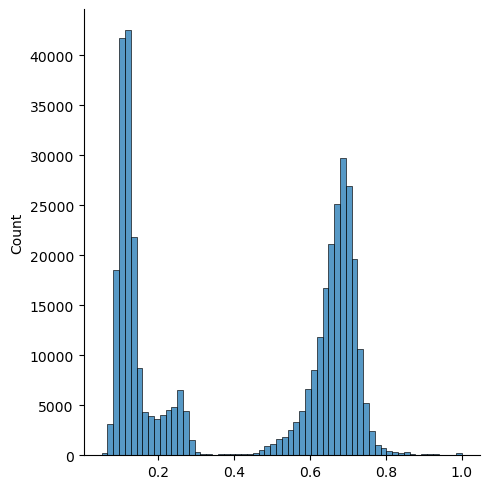

In [21]:
# show distplot of unscaled data
reshaped = np.reshape(sample, (np.prod(sample.shape[:-1]), sample.shape[-1]))
sns.displot(reshaped[:,1]);

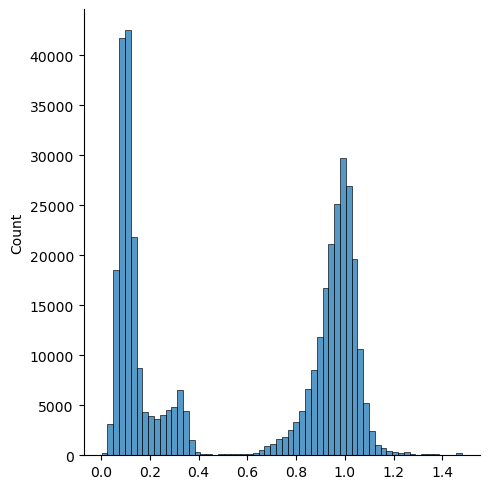

In [27]:
# show distplot of scaled data
sns.displot(unseen_ss[:,1]);

In [ ]:
preds = predict_classification(unseen_ss, model, sample_dims)
write_tif(preds, bbx, tile_idx, country, 'preds')

### Ashanti

In [2]:
ashanti = pd.read_csv('../data/ashanti.csv')
ashanti.head()

,X,Y,Y_tile,X_tile,country,tile_idx
0,-1.4167,7.5833,1100,1660,Ghana,"(1660, 1100)"
1,-1.3611,7.5833,1100,1661,Ghana,"(1661, 1100)"
2,-1.4167,7.5278,1099,1660,Ghana,"(1660, 1099)"
3,-1.3611,7.5278,1099,1661,Ghana,"(1661, 1099)"
4,-1.0278,7.5278,1099,1667,Ghana,"(1667, 1099)"


In [3]:
# create a list of tiles 
ashanti_tiles = ashanti[['X_tile', 'Y_tile']].to_records(index=False)

In [4]:
# run predictions on all the tiles using manually scaled model w/ no feats
counter = 0

for tile in ashanti_tiles[:200]:
    counter += 1
    p.execute(tile, 'ashanti', 'cat_model_v11_nf')
    if counter % 5 == 0:
        print(f'{counter}/200 completed.')

Exists locally.
ERROR! Session/line number was not unique in database. History logging moved to new session 483
Writing ../tmp/ashanti/preds/1660X1100Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1661X1100Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1660X1099Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1661X1099Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1667X1099Y_preds.tif
5/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1673X1099Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1658X1098Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1659X1098Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1660X1098Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1661X1098Y_preds.tif
10/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1662X1098Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1666X1098Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1667X1098Y_preds.tif
Exists loca

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


Writing ../tmp/ashanti/preds/1650X1095Y_preds.tif
70/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1651X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1652X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1653X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1654X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1655X1095Y_preds.tif
75/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1656X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1657X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1658X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1659X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1660X1095Y_preds.tif
80/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1661X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1662X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1663X1095Y_preds.tif
Exists locally.
Writing ../tmp/ashanti

Writing ../tmp/ashanti/preds/1650X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1651X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1652X1091Y_preds.tif
190/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1653X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1654X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1655X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1656X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1657X1091Y_preds.tif
195/200 completed.
Exists locally.
Writing ../tmp/ashanti/preds/1658X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1659X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1660X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1661X1091Y_preds.tif
Exists locally.
Writing ../tmp/ashanti/preds/1662X1091Y_preds.tif
200/200 completed.


In [6]:
m.mosaic_tif('ashanti', 'cat_model_v11_nf', '071122')

Merging 199 tifs.


In [4]:
# run for ashanti using manually scaling workflow
ashanti = pd.read_csv('../data/ashanti.csv')

# create a list of tiles 
ashanti_tiles = ashanti[['X_tile', 'Y_tile']].to_records(index=False)

for tile in ashanti_tiles:
    p.execute(tile, 'ashanti', 'cat_model_v8_nf_scaledman')

Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.4326530396938324, 0.09245425462722778, 0.043595027178525925, 0.06770428270101547, 0.0626993179321289, 0.17644973397254943, 0.1125899039208889, 0.16024562120437622, 0.17871151641011238, 0.20054016411304473, 0.22741328850388526, 0.1472014382481575]
[0.07088188827037811, 0.659546971321106, 0.3704010844230652, 0.09758410342037677, 0.1335641473531723, 0.18339818716049194, 0.3029360488057136, 0.21954596638679502, 0.2647858098149298, 0.29309731721878046, 0.32958030849695186, 0.4120339840650557, 0.35629234164953205]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1660X1100Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.4558485448360443, 0.12936119735240936, 0.046799421310424805, 0.07211495153605937, 0.06199740618467331, 0.19470511376857758, 0.11695126220583915, 0.17206196784973143, 0.19325789511203767, 0.221905136853

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1666X1098Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000004
[0.0, 0.541735053062439, 0.24083015322685242, 0.03925386648625136, 0.06204054057598114, 0.04864889718592167, 0.17083961814641951, 0.09886102527379989, 0.15789385065436362, 0.176850388944149, 0.20027757659554482, 0.1790342189371586, 0.09938251003623008]
[0.07088188827037811, 0.6817461252212524, 0.38304221630096436, 0.06940587535500525, 0.100589307770133, 0.11374837905168533, 0.2743490740656852, 0.15730079486966125, 0.2334351651370525, 0.2660564184188842, 0.29515342563390734, 0.3030822813510893, 0.23408624082803714]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1667X1098Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0
[0.0, 0.5359043478965759, 0.24518950283527374, 0.038772862404584885, 0.06315618157386779, 0.04720378294587135, 0.17327697649598123, 0.10109252631664276, 0.

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1651X1097Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0
[0.0, 0.47188857197761536, 0.1464889645576477, 0.033844511955976486, 0.051499199122190475, 0.03849851340055466, 0.20370030403137207, 0.08073603808879852, 0.17714094817638398, 0.19980553612113, 0.2265629768371582, 0.18625938296318054, 0.0879235714673996]
[0.1589212715625763, 0.7655596733093262, 0.4439806342124939, 0.06604868173599243, 0.09549859166145325, 0.11574731022119522, 0.33080035001039504, 0.15190704762935636, 0.25882824957370754, 0.31453598141670225, 0.348134434223175, 0.324387066066265, 0.2469593361020088]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1652X1097Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000004
[0.0, 0.4400586783885956, 0.10422606766223907, 0.03999389708042145, 0.0630960538983345, 0.047096842899918556, 0.20869764685630798, 0.09778376817703247, 0.1

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1668X1097Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.5337730646133423, 0.24832743406295776, 0.035545893013477325, 0.05894560366868973, 0.04068817496299744, 0.1652349479496479, 0.0950176790356636, 0.14781393855810165, 0.1690518654882908, 0.18570285364985467, 0.1776824414730072, 0.10153081193566323]
[0.08943852037191391, 0.685890793800354, 0.3961414396762848, 0.062401771545410156, 0.09085221588611603, 0.09699346385896199, 0.28714806139469096, 0.1366963744163513, 0.23840280771255473, 0.27596467137336717, 0.3061008870601652, 0.26880242228507994, 0.1958000853657722]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1669X1097Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.5241138935089111, 0.23440000414848328, 0.03340199645608664, 0.05624270532280207, 0.03530174493789673, 0.17859922349452972, 0.0909

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1653X1096Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.42827141284942627, 0.08560952544212341, 0.03889056947082281, 0.06050202250480652, 0.04280155524611473, 0.2030608132481575, 0.09566262364387512, 0.17998221144080162, 0.20498896166682243, 0.22981395423412324, 0.1986358121037483, 0.10291806161403656]
[0.0998319610953331, 0.7077476978302002, 0.39861759543418884, 0.07539482414722443, 0.108587396889925, 0.1432512842118734, 0.3687953054904938, 0.17768940329551697, 0.287936495244503, 0.35342670083045946, 0.38328368663787826, 0.3525728061795233, 0.28588339388370504]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1657X1096Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000004
[0.0, 0.43703141808509827, 0.09374441206455231, 0.03882531076669693, 0.060229160264134406, 0.046601053327322006, 0.19655147194862366, 0.096

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1668X1096Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5453898906707764, 0.25698673725128174, 0.03630121424794197, 0.059601739048957825, 0.0445013951510191, 0.18214763402938844, 0.09554968476295471, 0.16316802501678468, 0.18593645244836807, 0.209648434817791, 0.18285067677497863, 0.10134468860924244]
[0.08943852037191391, 0.6858005523681641, 0.396462082862854, 0.06409751549363131, 0.09340047836303711, 0.10149538516998291, 0.291302353143692, 0.14260881617665275, 0.2457403436303138, 0.28471919298171955, 0.31289285123348237, 0.28411762863397594, 0.20359851121902456]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1669X1096Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5408703088760376, 0.26633548736572266, 0.03350118175148964, 0.05674830079078674, 0.03675135225057602, 0.18219387009739876, 0.0922

../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.5054888129234314, 0.20356039702892303, 0.02791101988404989, 0.051544979214668274, 0.028508918546140193, 0.21300776451826095, 0.08866120092570781, 0.18772120773792267, 0.21479470431804656, 0.2392136797308922, 0.19985719546675682, 0.09732737094163894]
[0.12566591799259186, 0.7231771349906921, 0.41643351316452026, 0.06618114486336706, 0.09923139512538902, 0.11159994304180137, 0.4273969128727912, 0.15616722926497453, 0.3424229919910431, 0.41786906719207717, 0.44828310012817385, 0.32328184098005286, 0.22617272660136215]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1650X1095Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.464541494846344, 0.1254856288433075, 0.03595025837421417, 0.05645075440406799, 0.042153045535087585, 0.20253030136227607, 0.0940570842474699, 0.1848151259124279, 0.20573486760258675, 0.2230764962732792, 0.20859

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1661X1095Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000002
[0.0, 0.459983229637146, 0.1330977827310562, 0.04160372167825699, 0.0644998848438263, 0.05064767561852932, 0.2068970799446106, 0.10080447532236576, 0.17962125167250634, 0.20505128502845765, 0.2331439085304737, 0.20123487561941147, 0.1073057021945715]
[0.07088188827037811, 0.7204694747924805, 0.41628390550613403, 0.09952348694205283, 0.13820096850395203, 0.17900256887078275, 0.33134878575801835, 0.22377872765064238, 0.2807743579149244, 0.31426867693662636, 0.3503700509667396, 0.40356338769197464, 0.33600011765956866]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1662X1095Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.4688764810562134, 0.15200254321098328, 0.03990234434604645, 0.06461150124669075, 0.05284962058067322, 0.19535362720489502, 0.10486

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1673X1095Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5493563413619995, 0.2683873474597931, 0.029251545667648315, 0.04625009745359421, 0.03160898145288229, 0.16444647312164307, 0.07672346532344818, 0.14477935060858727, 0.16786651611328124, 0.19184016510844232, 0.16041097193956375, 0.07836406901478768]
[0.12942928075790405, 0.708964467048645, 0.42002004384994507, 0.04929427057504654, 0.07280079275369644, 0.08025470450520514, 0.27719365507364246, 0.117844247072935, 0.2205266535282135, 0.26484756469726556, 0.2948520779609678, 0.2305056072771549, 0.15454280227422712]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1674X1095Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5457442998886108, 0.27034813165664673, 0.0272449835203588, 0.04385443031787872, 0.02999923750758171, 0.1654459536075592, 0.07617

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1656X1094Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000004
[0.0, 0.4153267741203308, 0.06801068037748337, 0.03757490497082472, 0.060667667724192145, 0.0471961535513401, 0.19652548655867577, 0.09944020360708236, 0.17433423697948455, 0.19653283283114434, 0.22090208828449248, 0.21722148656845092, 0.11918805241584778]
[0.1589212715625763, 0.7309352159500122, 0.4099581837654114, 0.08610665798187256, 0.11999695003032684, 0.15649652481079102, 0.3459983170032501, 0.18768582344055174, 0.28083314895629874, 0.33888879865407934, 0.36793205738067625, 0.35249977260828014, 0.285457295179367]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1657X1094Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000002
[0.0, 0.44244247674942017, 0.10525521636009216, 0.03748942837119103, 0.057900357991456985, 0.04285496473312378, 0.19909971952438354, 0.

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1668X1094Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.5377594828605652, 0.25204503536224365, 0.03465323895215988, 0.058555318601429464, 0.041306172125041486, 0.18584725260734558, 0.09537424854934215, 0.1623064696788788, 0.1834116756916046, 0.21062272191047668, 0.17903058230876923, 0.0977042056620121]
[0.07088188827037811, 0.6901984810829163, 0.40137016773223877, 0.0633554607629776, 0.09069962799549103, 0.09649805724620819, 0.29420748054981216, 0.13507039695978162, 0.24507115855813016, 0.282437527179718, 0.310971075296402, 0.2675252109766003, 0.19559706076979638]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1669X1094Y_preds.tif
Exists locally.
(618, 612, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5503630638122559, 0.2736203670501709, 0.03299763426184654, 0.056000612676143646, 0.0401541143655777, 0.18473474830389022, 0.09301

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1680X1094Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.4676573872566223, 0.13413017988204956, 0.03790340945124626, 0.05882906414568424, 0.04170290753245354, 0.21930266916751862, 0.09508775196969509, 0.19001587569713593, 0.21485179662704468, 0.24933497473597527, 0.21224956661462785, 0.10763830602169037]
[0.13307473063468933, 0.7508922815322876, 0.43572545051574707, 0.06909285485744476, 0.10299839824438095, 0.12109559774398804, 0.33850613236427307, 0.16176000118255615, 0.2738093042373657, 0.3228741610050201, 0.3570868289470672, 0.34275124937295914, 0.2562622758746147]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1652X1093Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000002
[0.0, 0.48570626974105835, 0.1659345179796219, 0.035797666758298874, 0.0540812573954463, 0.039067733958363535, 0.20279240608215332, 0.

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1663X1093Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.4761112928390503, 0.17515793442726135, 0.03799496591091156, 0.06083492770791054, 0.04240482300519943, 0.18559548258781433, 0.09602974571287631, 0.16043097734451295, 0.18033638060092927, 0.20838294580578803, 0.18826314494013785, 0.09525097027420998]
[0.08943852037191391, 0.7128449082374573, 0.42589426040649414, 0.06889448314905167, 0.10220492631196976, 0.11740291118621826, 0.32410162687301636, 0.1593903250992298, 0.2599884474277496, 0.30617575794458385, 0.33942978620529174, 0.3218635457754135, 0.24451982498168937]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1664X1093Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.4595273733139038, 0.1527761071920395, 0.03329518437385559, 0.05342643722891808, 0.03849851340055466, 0.17070268094539642, 0.0

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1675X1093Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000002
[0.0, 0.5231528878211975, 0.257411390542984, 0.0283727240934968, 0.04735637456178665, 0.03440580539405346, 0.17209887504577637, 0.07752409741282464, 0.15068332314491273, 0.17490178793668748, 0.20362551033496856, 0.1630753356218338, 0.08191917315125466]
[0.13307473063468933, 0.712770402431488, 0.42801225185394287, 0.04957565382122993, 0.08055009312927719, 0.07970550656318665, 0.3100489205121994, 0.12653162121772765, 0.259899441897869, 0.3021803420782089, 0.3295198851823807, 0.2638793131709098, 0.1731949317455288]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1676X1093Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0, 1.0000000000000004
[0.0, 0.5299944877624512, 0.2639082670211792, 0.02861912429332733, 0.046852827072143555, 0.034103915095329285, 0.16550159692764282, 0.07663781829178333, 0.14

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1657X1092Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000004, 1.0000000000000002
[0.0, 0.5261129140853882, 0.21148452162742615, 0.032448310405015945, 0.051506828516721725, 0.0349289158731699, 0.21725031733512878, 0.08562704585492611, 0.18862994253635407, 0.21802592024207115, 0.24405115753412246, 0.18631863877177238, 0.08910560242831707]
[0.14004869759082794, 0.7511378526687622, 0.4339234232902527, 0.06417400822043418, 0.09444572031497955, 0.1133020606637001, 0.3686817362904548, 0.15340459346771237, 0.2959138303995132, 0.3632314610481262, 0.3918756344914436, 0.309222157895565, 0.2200461134314536]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1658X1092Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000004, 1.0
[0.0, 0.4692062437534332, 0.14061060547828674, 0.03310444951057434, 0.05268600836396217, 0.03804837167263031, 0.20244908332824707, 0.08801141858100892, 0

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1669X1092Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000007
[0.0, 0.5376165509223938, 0.25051385164260864, 0.031534882374107835, 0.05501654781401157, 0.041847869753837585, 0.18985831573605538, 0.09385819271206856, 0.16630060389637946, 0.18940940737724304, 0.2169317901134491, 0.18014912873506547, 0.09569078274071216]
[0.08943852037191391, 0.6835419535636902, 0.4008978009223938, 0.05870145559310913, 0.08450446277856827, 0.0968025642633438, 0.289752978682518, 0.13501987114548683, 0.2393413481116295, 0.2785572987794875, 0.30935026377439484, 0.2804197770357132, 0.20025646105408668]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1670X1092Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000004
[0.0, 0.5233142375946045, 0.252750962972641, 0.030701152980327606, 0.05350417502224446, 0.03680476173758507, 0.18209742188453676, 0.0862

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1651X1091Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.5493723154067993, 0.24631327390670776, 0.032700084149837494, 0.051392387598752975, 0.03564813498407602, 0.2227969765663147, 0.0815824469923973, 0.19703801706433297, 0.22715963646769524, 0.24634570747613907, 0.1838194787502289, 0.08375998504459858]
[0.17547965049743652, 0.7462284564971924, 0.4313574433326721, 0.0791943222284317, 0.11279271394014355, 0.14950120836496336, 0.3987029790878296, 0.17693740665912627, 0.31694498360157014, 0.38623541593551636, 0.4182896223664283, 0.31115168988704667, 0.24726921170949934]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1652X1091Y_preds.tif
Exists locally.
(618, 614, 13)
The data has been scaled to -1.0000000000000002, 1.0000000000000002
[0.0, 0.567051887512207, 0.26152509450912476, 0.03345633666962385, 0.050049591809511185, 0.033246522434055806, 0.23847746938467027, 0.0

Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1663X1091Y_preds.tif
(618, 614, 13)
The data has been scaled to -1.0, 1.0000000000000004
[0.0, 0.47493427991867065, 0.173214390873909, 0.035599298775196075, 0.05830472335219383, 0.042153049260377884, 0.19534599781036377, 0.09392631843686104, 0.17255425453186035, 0.19372548937797546, 0.21804092824459076, 0.1930649012327194, 0.09924821712076665]
[0.1135486364364624, 0.7491159439086914, 0.44357478618621826, 0.07074844837188721, 0.10295261442661285, 0.12995567128062244, 0.350928236246109, 0.16534654125571244, 0.2806258314847946, 0.34146575272083274, 0.3702948361635208, 0.32261429548263537, 0.2548203340172767]
Predictions: [0. 1.]
Writing ../tmp/ashanti/preds/1664X1091Y_preds.tif


KeyboardInterrupt: 

In [6]:
## Mosaic and save with date
m.mosaic_tif('ashanti', 'cat_model_v8_nf_scaledman', '110222')

Merging 201 tifs.


### New Abirem

In [17]:
# create csv for abirem
ghana = pd.read_csv('../data/ghana.csv')
ab = ghana[(ghana.X_tile >= 1667) & (ghana.X_tile <= 1671)]
ab = ab[(ab.Y_tile <= 1077) & (ab.Y_tile >= 1073)]

In [2]:
ab = pd.read_csv('../data/abirem.csv')
abirem_tiles = ab[['X_tile', 'Y_tile']].to_records(index=False)
abirem_tiles

rec.array([(1667, 1077), (1668, 1077), (1669, 1077), (1670, 1077),
           (1671, 1077), (1667, 1076), (1668, 1076), (1669, 1076),
           (1670, 1076), (1671, 1076), (1667, 1075), (1668, 1075),
           (1669, 1075), (1670, 1075), (1671, 1075), (1667, 1074),
           (1668, 1074), (1669, 1074), (1670, 1074), (1671, 1074),
           (1667, 1073), (1668, 1073), (1669, 1073), (1670, 1073),
           (1671, 1073)],
          dtype=[('X_tile', '<i8'), ('Y_tile', '<i8')])

In [17]:
## run predictions for abirem 
model = 'rfr_model_v11_nf'
for tile in abirem_tiles[1:2]:
    p.execute(tile, 'abirem', model)

Exists locally.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


[[ 0.  3.  7. ... 32. 46. 40.]
 [ 0.  5.  1. ... 14. 50. 21.]
 [ 0.  1. 11. ... 21. 21. 14.]
 ...
 [83. 62. 82. ... 84. 83. 85.]
 [80. 66. 73. ... 78. 79. 87.]
 [74. 74. 72. ... 75. 83. 88.]]
Writing ../tmp/abirem/preds/1668X1077Y_preds.tif


In [4]:
m.mosaic_tif('abirem', 'rfr_model_v11_nf', '091122')

Merging 25 tifs.


<AxesSubplot:>

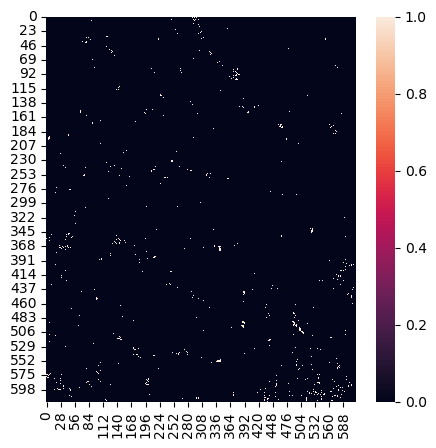

In [14]:
plt.figure(figsize=(5,5))
preds = rs.open('../tmp/abirem/preds/1668X1077Y_preds.tif').read(1)

sns.heatmap(preds)

## Manual Scaling

In [222]:
# import the mins and maxs for v11 training data
mins = np.load('../data/mins_v11.npy')
maxs = np.load('../data/maxs_v11.npy')

In [237]:
# grab the sample data
unseen = p.execute((1660, 1075), 'ashanti', 'cat_model_v11', feats=True)

Exists locally.


In [238]:
# unscaled data
unseen.shape

(618, 614, 78)

In [246]:
# min and max for band 0, which is DEM
unseen[0].min(), unseen[0].max()

(-1.194000005722046, 99.0)

In [247]:
# training data min and max for band 0
mins[0], maxs[0]

(0.0, 0.2163468897342682)

In [248]:
# min and max for band 0, which is DEM
unseen[1].min(), unseen[1].max()

(-1.1670000553131104, 98.0)

In [249]:
# training data min and max for band 0
mins[1], maxs[1]

(0.14710162580013275, 0.37328264117240906)

In [2]:
## bring in training data for west africa
X, y = ptype.create_xy((14, 14), ['v08', 'v11'], drop_prob=False, drop_feats=False, verbose=False)

Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Baseline: 0.409


In [55]:
X.shape

(313, 14, 14, 78)

In [57]:
X.min(), X.max()

(-1.7478961944580078, 40527.5)

In [52]:
## bring in unseen data for west africa
sample, sample_dims = p.execute((1658,1074), 'ashanti', 'cat_model_v11')

Exists locally.


../src/cloud_removal.py:190: RuntimeWarning: invalid value encountered in true_divide
  mosaic = mosaic / divisor


(618, 614, 78)


In [63]:
min_all = []
max_all = []

for band in range(0, X.shape[-1]):
    mins = np.percentile(X[..., band], 1)
    maxs = np.percentile(X[..., band], 99)
    
    if maxs > mins:

        # clip values outside interval of min - max for that band
        # this might need to be unseen
        X[..., band] = np.clip(X[..., band], mins, maxs)

        # now calculate standardized data for unseen
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (X[..., band] - midrange) / (rng / 2)

        # update each band in unseen to the standardized data
        X[..., band] = standardized

        min_all.append(mins)
        max_all.append(maxs)
    else:
        pass

In [64]:
max_all

[0.2163468897342682,
 0.37404465675354004,
 0.07852332293987274,
 5772.529999999999,
 7948.264999999999,
 9641.265,
 28543.765,
 12536.149999999994,
 23461.79999999999,
 28726.414999999994,
 30824.444999999992,
 24151.064999999988,
 19192.53,
 0.981483314037323,
 2.4606036472320545,
 1.6546414792537683,
 -0.38799973249435443,
 1.2764286530017843,
 0.0036377086373976016,
 1.406461414098739,
 -0.18347126483917242,
 2.347606451511382,
 0.6267054188251484,
 2.555902326107025,
 2.8596210169792173,
 0.29107718914747155,
 -0.02929449677467363,
 1.7447328758239744,
 2.2615721344947812,
 0.3064852505922309,
 3.8663720417022693,
 3.138309018611907,
 -0.0785138399153948,
 -0.07332813970744644,
 2.23050978899002,
 0.9233808380365368,
 1.5352355420589445,
 -0.41245952665805824,
 0.033953454270958854,
 3.001175122261046,
 2.1461652708053585,
 -0.026329627465457077,
 2.0955630040168756,
 1.016310257911682,
 1.4483801138401022,
 0.8799912375211711,
 0.29219371140003203,
 0.4502807286381721,
 0.4203458

In [65]:
min_all

[0.0,
 0.14873744547367096,
 0.03137637674808502,
 1849.5,
 3076.0,
 1971.7350000000001,
 14315.97,
 4482.235,
 12231.735,
 14227.235,
 15842.0,
 9402.235,
 4205.235,
 0.035097129940986634,
 -0.9327185106277466,
 -0.6478016418218613,
 -1.6069760942459106,
 -0.6522527074813843,
 -0.5679909294843674,
 -0.619753189086914,
 -0.5520985239744186,
 -0.39657537430524825,
 -0.8860316503047944,
 -0.5840837746858597,
 -0.7147808766365051,
 -0.6348849588632584,
 -0.9395528930425644,
 -0.5081062722206116,
 -0.6634011453390122,
 -0.9442471724748611,
 -0.4446402180194855,
 -0.5559357452392578,
 -0.6196065419912338,
 -0.8015996927022934,
 -0.7606151342391968,
 -0.7031940370798111,
 -0.23004623740911484,
 -0.8559035915136337,
 -0.6760245192050934,
 -0.7412290757894516,
 -0.5088179975748062,
 -0.7080219447612762,
 -0.32299757331609724,
 -0.9040744537115097,
 -1.150347421169281,
 -0.8029187500476838,
 -0.45620909512043,
 -0.4166562706232071,
 -0.03091299949213862,
 -0.4000528311729431,
 -0.40184633791446

In [53]:
sample.shape

(618, 614, 78)

In [ ]:


def reshape_and_scale_manual(v_train_data: list, unseen, verbose=False):

    ''' 
    Manually standardizes the sample on a 1, 99% scaler 
    instead of applying a mean, std scaler. Then reshapes the sample
    from (x, x, 13) to (x, 13).
    '''
    # prepare original training data 
    X, y = prepare_data.create_xy((14,14), v_train_data, drop_prob=False, drop_feats=False, verbose=False)

    # MANUALLY standardize train/test data 
    min_all = []
    max_all = []

    # iterate through the 10 bands and standardize the data based 
    # on a 1 and 99% scaler instead of a mean and std scaler (standard scalar)
    for band in range(0, X.shape[-1]):
        
        mins = np.percentile(X[..., band], 1)
        maxs = np.percentile(X[..., band], 99)
        
        if maxs > mins:
            
            # clip values outside interval of min - max for that band
            # this might need to be unseen
            unseen[..., band] = np.clip(unseen[..., band], mins, maxs)

            # now calculate standardized data for unseen
            midrange = (maxs + mins) / 2
            rng = maxs - mins
            standardized = (unseen[..., band] - midrange) / (rng / 2)

            # update each band in unseen to the standardized data
            unseen[..., band] = standardized

            min_all.append(mins)
            max_all.append(maxs)
        else:
            pass
    
    if verbose:
        print(unseen.shape)
        print(f"The data has been scaled to {np.min(unseen)}, {np.max(unseen)}")
        print(min_all)
        print(max_all)

    # now reshape
    unseen_reshaped = np.reshape(unseen, (np.prod(unseen.shape[:-1]), unseen.shape[-1]))

    return unseen_reshaped

## Mosaic Error

In [73]:
filename = 'test_merge'
gdal.BuildVRT(f'../tmp/preds/{str(filename)}.vrt', tifs_to_mosaic, options=gdal.BuildVRTOptions(srcNodata=255, VRTNodata=255))
#translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-ot Byte -co COMPRESS=LZW -a_nodata 255 -co BIGTIFF=YES"))
translateoptions = gdal.TranslateOptions(format='Gtiff', 
                                          outputSRS='EPSG:4326',
                                          outputType=gdal.GDT_Byte,
                                          noData=255,
                                          creationOptions=['COMPRESS=LZW', 'BIGTIFF=YES'])
                                         

ds = gdal.Open(f'../tmp/preds/{str(filename)}.vrt')
ds = gdal.Translate(f'../tmp/preds/{str(filename)}.tif', ds, options=translateoptions)



Warning 1: Can't open 1677X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1678X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1674X1085Y_preds.tif. Skipping it
Warning 1: Can't open 1680X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1676X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1679X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1660X1161Y_preds.tif. Skipping it
Warning 1: Can't open 1678X1163Y_preds.tif. Skipping it
Warning 1: Can't open 1666X1161Y_preds.tif. Skipping it
Warning 1: Can't open 1679X1163Y_preds.tif. Skipping it
ERROR 4: ../tmp/preds/test_merge.vrt: No such file or directory


ValueError: Received a NULL pointer.

## Confirm Cloud Removal

In [20]:
# test workflow with John's input data
# perform steps in jupyter
tile_idx = (1644, 1052)
s1 = np.load('problem_tile/s1_median.npy')
s2 = np.load('problem_tile/s2_median.npy')
s2 = s2[:,:,:10]
slope = np.load('problem_tile/slope.npy')

print(s1.shape, s2.shape, slope.shape)

(618, 616, 2) (618, 616, 10) (618, 616)


In [21]:
bbx_df, bbx = p.make_bbox('ghana', (tile_idx[0], tile_idx[1]))

In [22]:
sample, sample_dims = p.make_sample_nofeats(slope, s1, s2)

features: 13
sample shape: (618, 616, 13)


In [27]:
preds = predict_classification(unseen_ss, 'cat_model_v8_nf', sample_dims)

[0.]


In [42]:
unseen_ss = p.reshape_and_scale(['v8'], sample, verbose=True)
preds = p.predict_classification(unseen_ss, model='cat_model_v8_nf', sample_dims=sample_dims)
p.write_tif(preds, bbx, tile_idx, 'ghana', suffix = 'check')

Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Xtrain Original: (146, 14, 14, 13) Xtrain Reshaped: (28616, 13)
Unseen Original: (618, 616, 13) Unseen Reshaped: (380688, 13)
Scaled to -4.609535471153089, 16.699078801004973
Scaled to -5.780272087379689, 15.175777554070143
[0. 1.]
Writing ../tmp/ghana/preds/1644X1052Y_check.tif


'../tmp/ghana/preds/1644X1052Y_check.tif'

In [49]:
s2_processed.shape

(4, 618, 616, 10)

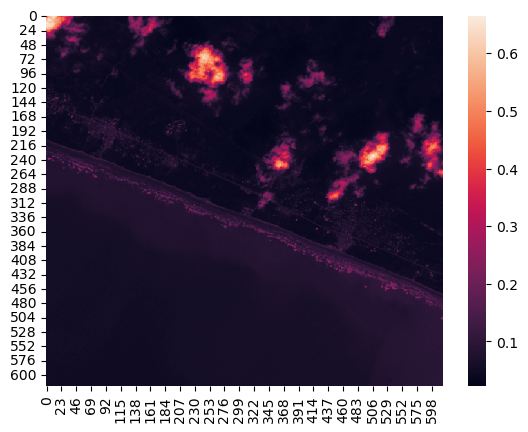

In [54]:
sns.heatmap(s2_processed[0, ..., 0]);